# AC Power estimation

<table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/CSTB_logo.jpg" width="200" />
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/Heliocity_logo.png" width="200" /> 
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>

This notebook introduces some tools to estimate the AC power production of a PV installation.

It is broken down into three parts:

1. **Data visualization**: Exploration of weather and PV data
2. **POA irradiance, temperature, and Power modeling**: Estimation temperature/DC power and comparison to real values.
3. **PR calculation**


The first part is used to introduce the subject and the attendees are expected to collaborate and develop detection methods in the parts 2 & 3.

**Make sure to manually execute the cells (ctrl + enter) yourself one by one**

Data: Scenario 1 from the 2021 PVPMC blind comparison

##### Caracteristics of the PV installation:
- 12 modules in series
- tilt: 35° 
- azimuth: 180° (south)
- albedo: 0.2 (assumption)

#####  Module datasheet
- 325 Wp
- Thermal (power) coefficient: -0.258 % /°C 
- NOCT: 43 °C

#####  Generic temperature oefficients for open-rack PV installation
- u_0 = 26.9 W/(˚C.m2)
- u_1 = 6.2 W.s/(˚C.m3)

## I. Data vizualization

In [4]:
# Please execute this cell to import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## I.1. In-situ weather data

Below is the weather inputs of the models to estimate the DC production. 

Execute the cell below to import it !

In [5]:
# Load satellite weather data: incident irradiation, direct irradiation, temperature, wind from online file
url="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/data/xtrain.csv"
weather_data = pd.read_csv(url, index_col=0) # Import a csv file from an url and fix the first column (0) as pandas index
weather_data.index = pd.to_datetime(weather_data.index) # Convert index to "datetime" index (to make it easier to manipulate)
print(weather_data.head(10)) # Show the first 10 lines

                                  ghi        dhi         dni  temp_air  \
2020-01-01 01:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 02:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 03:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 04:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 05:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 06:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 07:00:00-07:00    0.000000   0.000000    0.000000  0.000000   
2020-01-01 08:00:00-07:00   40.874978  14.742914  264.832939 -4.737162   
2020-01-01 09:00:00-07:00  185.738601  31.546335  754.498236 -3.652383   
2020-01-01 10:00:00-07:00  353.666975  40.138926  914.471581 -0.708700   

                           wind_speed  sun_azimuth  sun_elevation  
2020-01-01 01:00:00-07:00    0.000000    45.887005     -73.699678  
2020-01-01 02:00:00-07:00    0.000000    60.33037

Visualize the data with the plot below ! (Execute the cell)

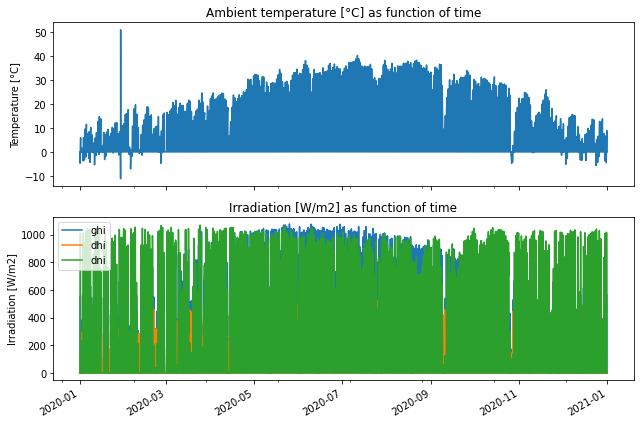

In [6]:
# Make a figure with two axes (two figures top/bottom) which share the same x axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6), sharex=True) 


# Show the Ambient temperature on the first axis "ax1" with a title and a temperature
weather_data["temp_air"].plot(ax=ax1, title="Ambient temperature [°C] as function of time",ylabel="Temperature [°C]")

# Show the three irradiance components on the second axis "ax2" [GHI, DHI, DNI]
meteo_plot = weather_data[["ghi","dhi", "dni"]] # Get the three relevant columns from the dataframe
meteo_plot.plot(ax=ax2, title="Irradiation [W/m2] as function of time", ylabel="Irradiation [W/m2]")

plt.tight_layout() # Resize automatically the figure to make it *pretty*

## II. DC power estimation

Modeling PV power from ghi/dhi/dni goes into four steps:

1. Modeling the POA irradiance.
2. Modeling the module cell temperature. 
3. Modeling the installation power production.
4. Modeling the installation inverter efficiency.


### II.1. POA irradiance

#### Exercice

Calculate the POA irradiance with the no-shading/isotropic assumption as introduced in the notebook "python_intro_poa"

In [12]:
beta=35
azimuth_inst = 180
rho=0.2

# The lazy way with the pvlib package
from pvlib.irradiance import get_total_irradiance

# Notice it takes degrees as inputs
poa_data = get_total_irradiance(beta, azimuth_inst, 90-weather_data["sun_elevation"], weather_data["sun_azimuth"],
                                weather_data["dni"], weather_data["ghi"], weather_data["dhi"], albedo=rho)
poa_data.head(12)

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2020-01-01 01:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 02:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 03:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 04:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 05:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 06:00:00-07:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-01-01 07:00:00-07:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 08:00:00-07:00,98.965639,84.816622,14.149017,13.409801,0.739216
2020-01-01 09:00:00-07:00,432.922776,400.869941,32.052835,28.693790,3.359045
2020-01-01 10:00:00-07:00,689.575320,646.669920,42.905400,36.509405,6.395995


### II.2. Cell temperature model

#### Exercice

Calculate the module temperature with, both, the Ross or Faiman model

In [13]:
NOCT  = 43 # From datasheet

# Generic coefficients for open-rack PV installation
u_0 = 26.9 # W/(˚C.m2)
u_1 = 6.2 # W.s/(˚C.m3)

In [14]:
def ross_model(ta, poa):
    k_ross = (43-20)/800
    t_mod = ta + k_ross * poa
    return t_mod

def faiman_model(ta, poa, ws):
    k_ross = (43-20)/800
    t_mod = ta + poa / (u_0 + u_1 * ws)
    return t_mod

In [15]:
t_mod =  ross_model(weather_data["temp_air"],  poa_data["poa_global"]) 
t_mod2 =  faiman_model(weather_data["temp_air"],  poa_data["poa_global"], weather_data["wind_speed"]) 

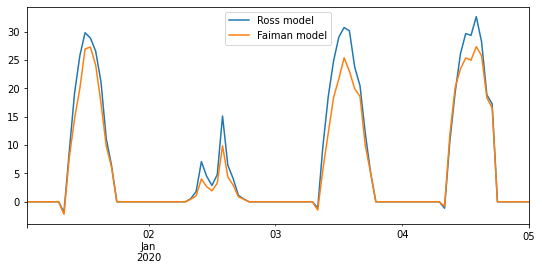

In [68]:
fig, ax = plt.subplots(figsize=(9,4)) # Create a new figure with a predefined size
t_mod.head(96).plot(ax=ax, label="Ross model")
t_mod2.head(96).plot(ax=ax, label="Faiman model")
plt.legend()

### II.3. DC power model

#### Exercice

Calculate the DC power with the PVwatts or Huld model

In [17]:
Pdc_0 = 12*325 #Wp Nominal power
gamma_pdc= -0.258/100 # [-]/°C

def pvwatts_dc(poa_global, t_mod, gamma_pdc):
    dc_power = Pdc_0 * poa_global / 1000 * (1 + gamma_pdc * (t_mod - 25)) 
    return dc_power

In [31]:
dc_power = pvwatts_dc(poa_data["poa_global"], t_mod, gamma_pdc)
dc_power2 = pvwatts_dc(poa_data["poa_global"], t_mod2, gamma_pdc)

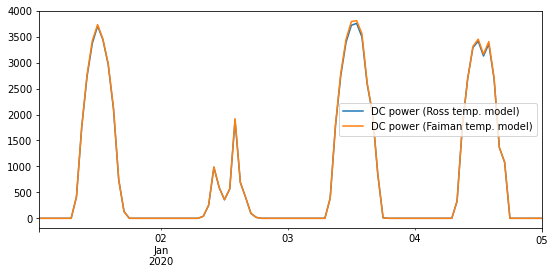

In [38]:
fig, ax = plt.subplots(figsize=(9,4)) # Create a new figure with a predefined size
dc_power.head(96).plot(ax=ax, label="DC power (Ross temp. model)")
dc_power2.head(96).plot(ax=ax, label="DC power (Faiman temp. model)")

plt.legend() # Print the labels

### II.4. AC power model



#### Exercice

Calculate the AC power with the PVWatts inverter model (create a function for that purpose !)

<AxesSubplot:>

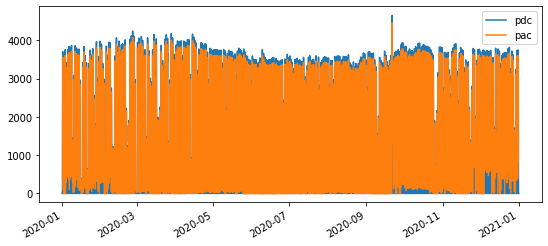

In [39]:
# Adapted from pvlib, 
def pvwatts_inverter(pdc, pdc0, eta_inv_nom=0.96, eta_inv_ref=0.9637):

    pac0 = eta_inv_nom * pdc0
    zeta = pdc / pdc0

    # Avoid to divide by 0 for array
    if type(zeta) is float:
        if zeta==0:
            zeta=np.nan
    else:
        zeta[zeta==0] = np.nan
    
    eta = eta_inv_nom / eta_inv_ref * (-0.0162 * zeta - 0.0059/zeta + 0.9858)
    
    # Make sure efficiency is between 0% and 100%
    eta = eta.clip(lower=0, upper=1)
    
    power_ac = eta * pdc

    return power_ac


ac_power = pvwatts_inverter(dc_power, Pdc_0)

# Create a new data frame with the values to plot
df = pd.DataFrame()
df["pdc"] = dc_power
df["pac"] = ac_power

fig, ax = plt.subplots(figsize=(9,4)) # Create a new figure with a predefined size
df.plot(ax=ax)

### III. Performance Ratio calculation

In this section, the performance and the model accuracies are assessed.

Actuals are imported in this section by executing the cell below.

g_poa: Global irradiance [W/m²]

t_mod: Module Temperature [°C]

pdc: DC power [W]

In [42]:
# Load actual data
url = "https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/data/ytrain.csv"
actual = pd.read_csv(url, index_col=0) 
actual.index = pd.to_datetime(actual.index)
print(actual.head(10))

                                 gpoa      t_mod          pdc
2020-01-01 01:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 02:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 03:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 04:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 05:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 06:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 07:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 08:00:00-07:00   26.144398  -7.713991   284.904857
2020-01-01 09:00:00-07:00  441.739142   5.177106  1481.974075
2020-01-01 10:00:00-07:00  700.841725  15.212283  2690.471151


#### Exercice

Calculate the PR and the Energy Performance Index

In [43]:
PR = actual["pdc"].sum() / actual["gpoa"].sum() / (Pdc_0/1000)

print(f"PR {round(PR*100,1)} %")

PR 88.1 %


In [44]:
PR_mod = dc_power.sum() / poa_data["poa_global"].sum() / (Pdc_0/1000)
print(f"PR_expected: {round(PR_mod*100,1)} %")

EPI = PR/PR_mod

print(f"EPI {round(EPI*100,1)} %")

PR_expected: 95.5 %
EPI 92.3 %


#### Exercice, to go further 

- What is the accuracy of the values compared to the real values imported below ? 

Calculate the Mean Error and Mean Absolute Error

Mean Biais: -7.73 W/m²
MAE: 14.42 W/m²
MAE: 2.9 %


<AxesSubplot:>

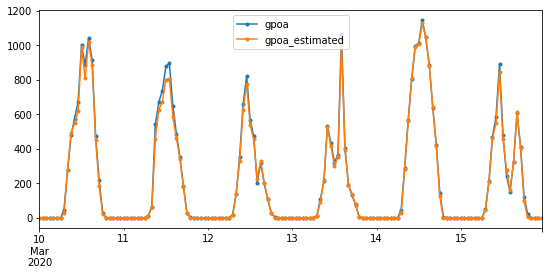

In [67]:
df = pd.DataFrame()
df["gpoa"] = actual["gpoa"]
df["gpoa_estimated"] = poa_data["poa_global"]

filter = df["gpoa"] > 0
print(f'Mean Biais: {round((df.loc[filter, "gpoa_estimated"] -df.loc[filter,"gpoa"]).mean(),2)} W/m²')
print(f'MAE: {round((df.loc[filter, "gpoa_estimated"] -df.loc[filter,"gpoa"]).abs().mean(),2)} W/m²')
print(f'MAE: {round((df.loc[filter, "gpoa_estimated"] -df.loc[filter,"gpoa"]).abs().mean()/df.loc[filter, "gpoa"].mean()*100,2)} %')

df.loc["20200310":"20200315"].plot(figsize=(9,4), marker=".")

Mean Error: 4.35 °C
MAE: 4.58 °C


<AxesSubplot:>

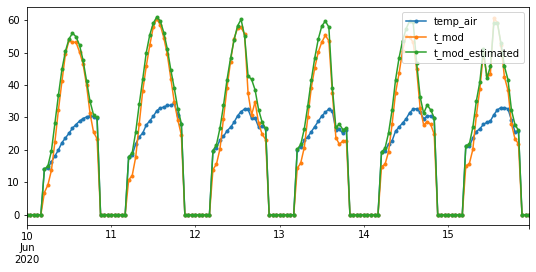

In [64]:
df = pd.DataFrame()
df["temp_air"] = weather_data["temp_air"]
df["t_mod"] = actual["t_mod"]
df["t_mod_estimated"] = t_mod

# The error value when GPOA > 10 W/m²
filter = (actual["gpoa"] > 0)
print(f'Mean Error: {round((df.loc[filter, "t_mod_estimated"] -df.loc[filter,"t_mod"]).mean(),2)} °C')
print(f'MAE: {round((df.loc[filter, "t_mod_estimated"] -df.loc[filter,"t_mod"]).abs().mean(),2)} °C')

df.loc["20200610":"20200615"].plot(figsize=(9,4), marker=".")

Mean Biais: 73.28 W
MAE: 95.47 W
MAE: 5.42 %


<AxesSubplot:>

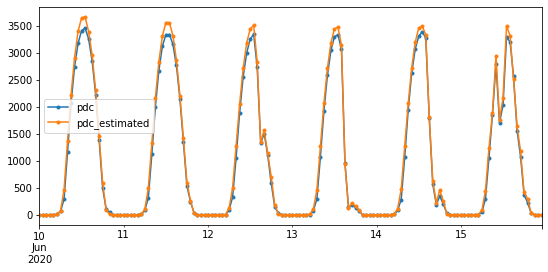

In [61]:
df = pd.DataFrame()
df["pdc"] =actual["pdc"]
df["pdc_estimated"] = dc_power

filter = (df["pdc"] > 1)  & (actual["gpoa"] > 0)
error = df.loc[filter, "pdc_estimated"] -df.loc[filter,"pdc"]

print(f'Mean Biais: {round(error.mean(),2)} W')
print(f'MAE: {round(error.abs().mean(),2)} W')
print(f'MAE: {round(error.abs().mean()/df.loc[filter, "pdc"].mean()*100,2)} %')

df.loc["20200610":"20200615"].plot(figsize=(9,4), marker=".")